# Argo Oxygen Gradient Analysis

This notebook to provide code for analysis of oxygen gradients (dO2/dz) in relation to the time response of oxygen optodes, and to what magnitude we might expect the lag correction to change existing profiles. It is also meant to provide context for how many floats and/or profiles are probably "bad" due to this inherent sensor error.

## 1 - Import relevant packages and load Argo oxygen data

The following code grabs the index of Argo profiles that contain dissolved oxygen data, subsets it for profiles more recent than 2016, and then further subsets it to be a random selection of those profiles. The package [argopandas](https://argocanada.github.io/argopandas/released/#) is used to do the heavy lifting.

In [15]:
# numerics, data fetching/handling
import numpy as np
import pandas as pd
import argopandas as argo

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# set up some plotting preferences
sns.set(style='ticks', palette='colorblind')

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [40]:
# bgc argo index, DOXY floats only, ascending profiles only
bx = argo.bio_prof.subset_parameter('DOXY').subset_direction('asc')
# this index is 240,000 profiles - reduce using date and random selection
bx = bx.subset_date('2016')
# random subset of N profiles
N = 500
bx = bx.iloc[np.unique((np.random.randint(0, bx.shape[0], size=((N,)))))]\
    .reset_index()\
    .drop('index', axis=1)
# get the data, throw out any missing oxygen
data = bx.levels[['PRES', 'DOXY']]

Reading 500 files                                                     


## 2 - Calculate the vertical gradient of oxygen for each profile

Next, calculate the vertical gradient of oxygen for each profile. For each of these gradients we will take the max absolute value, and fill it into a column in the profile index to make some things easier later on.

In [41]:
# confine ourselves to mid-depth
data = data[(data.PRES > 10) & (data.PRES < 500)]
# get rid of any invalid data
data = data[data.DOXY.notna()]
data = data[data.PRES.notna()]
# in case any files get completely removed because they are full of nan values
data.index = data.index.remove_unused_levels()
bx = bx[bx.file.isin(data.index.levels[0])]

# create column to store gradient data
data['GRAD'] = data.shape[0]*[np.nan]

# loop through each profile and calclualte/fill the gradient
for f in bx.file:
    profile = data.loc[f]
    grad = profile.DOXY.diff()/profile.PRES.diff()
    data.loc[f]['GRAD'][:] = grad

# remove any infinite values
data.GRAD[~np.isfinite(data.GRAD)] = np.nan
# fill in the max gradient for each profile
bx['max_grad'] = [data.loc[f].GRAD.abs().max() for f in bx.file]

## 3 - Visualize the data

Now, lets look at some oxygen profiles themselves, and the distribution of the gradients.

(-0.2, 10.2)

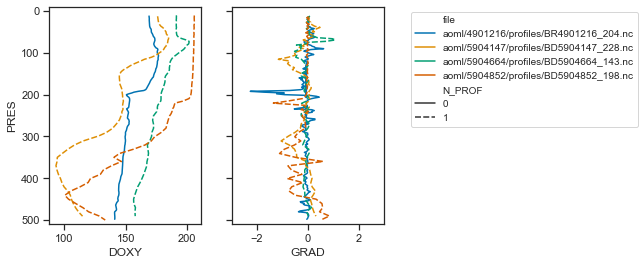

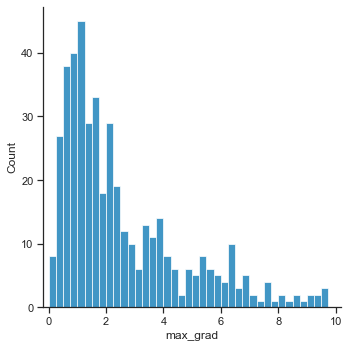

In [44]:
# plot oxygen profiles
fig, axes = plt.subplots(1, 2, sharey=True)
g1 = sns.lineplot(x='DOXY', y='PRES', hue='file', style='N_PROF', data=data.loc[bx.file.iloc[[1, 18, 57, 92]]], sort=False, ax=axes[0], legend=False)
# plot gradient profiles
g2 = sns.lineplot(x='GRAD', y='PRES', hue='file', style='N_PROF', data=data.loc[bx.file.iloc[[1, 18, 57, 92]]], sort=False, ax=axes[1])
g2.axes.set_ylim((510, -10))
g2.axes.set_xlim((-3, 3))
g2.axes.legend(fontsize=10, loc=1, bbox_to_anchor=(2.7, 1.0))

# next figure - max gradient distributions
# note - this is fundamentally flawed until you carefully remove spikes
g3 = sns.displot(bx.max_grad, bins=np.arange(0, 10, 0.25))
g3.ax.set_xlim((-0.2, 10.2))

In [9]:
grad

N_PROF  N_LEVELS
2       10               NaN
        11         -0.068258
        12         -0.148819
        13         -0.271098
        14         -0.255569
                      ...   
        250         0.155142
        251        -0.030209
        252        -0.190058
        253        -0.585357
        254        -0.096173
Length: 245, dtype: float32